In [2]:
!python ./prod/tok_data.py \
       --model-path './data/rnn/' \
       --corpus-fname './data/all_file.txt'\
       --out-pkl-name 'tweet_es_lmdata_0609.pkl'\
       --sp-model './all_tweets_es_0609' \
       --vocab-size 30000 \
       --batch-size 64 \
       --verbose 1 \
       --backward 0 \
       --model-type 'bpe'

ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
ModuleNotFoundError: No module named 'numpy.core._multiarray_umath'
> /home/bfarzin/haha_2019_final/prod/tok_data.py(31)build_sp_data()
-> PATH = Path(model_path)
(Pdb) 
--KeyboardInterrupt--
(Pdb) 

In [9]:
!ln -s ./prod/sp_tok.py ./

In [10]:
from prod.set_seed import random_ctl
seed = random_ctl()

from fastai.text import *
import sentencepiece as spm #https://github.com/google/sentencepiece
from fastai.layers import LabelSmoothingCrossEntropy
import fire
from sp_tok import *
    

Using seed: 504940


In [7]:
model_path = './data/rnn'
sp_model = 'all_tweets_es_0609'
data_pkl_name = 'tweet_es_lmdata_0609.pkl'
batch_size = 64
backward = 0
dropmult = 1.0
qrnn = True
n_hid:int=2304
flat_loss = True
wd=0.1
enc_name = 'twitter_es_enc_QRNN_0609_drop1_seed0_finetune'

In [21]:
PATH = Path(model_path)
defaults.text_spec_tok.append(NL) #add a New Line special char
sp_vocab = Vocab( get_itos(sp_model) )    
mycust_tok = CustomTokenizer(SPTokenizer, sp_model, pre_rules=default_rules)

data = load_data(PATH,data_pkl_name)
data.batch_size = batch_size #Titan RTX

config = awd_lstm_lm_config.copy()
config['qrnn'] = qrnn
config['n_hid'] = n_hid
print(config)
learn = language_model_learner(data, AWD_LSTM, drop_mult=dropmult, pretrained=False, config=config).to_fp16()
if flat_loss: learn.loss_func = FlattenedLoss(LabelSmoothingCrossEntropy)
print(learn.model)

{'emb_sz': 400, 'n_hid': 2304, 'n_layers': 3, 'pad_token': 1, 'qrnn': True, 'bidir': False, 'output_p': 0.1, 'hidden_p': 0.15, 'input_p': 0.25, 'embed_p': 0.02, 'weight_p': 0.2, 'tie_weights': True, 'out_bias': True}
SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(30000, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(30000, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=800, out_features=6912, bias=True)
            )
          )
        )
      )
      (1): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
              (module): Linear(in_features=2304, out_features=6912, bias=True)
            )
          )
        )
      )
      (2): QRNN(
        (layers): ModuleList(
          (0): QRNNLayer(
            (linear): WeightDropout(
        

In [22]:
learn.unfreeze()
lr_find(learn)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


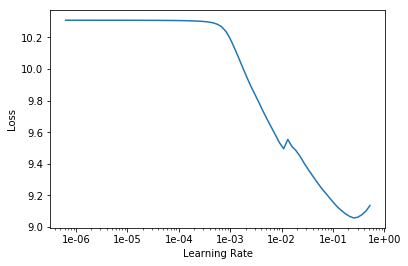

In [23]:
learn.recorder.plot(skip_end=15)

In [24]:
learn.fit_one_cycle(1, 5e-3, moms=(0.8,0.7), wd=wd)

epoch,train_loss,valid_loss,accuracy,time
0,5.478556,5.351773,0.291737,15:37


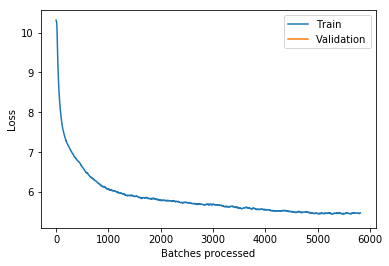

In [25]:
learn.recorder.plot_losses()

In [26]:
learn.save("LM_detail_first_epoch")

In [27]:
n_epochs = 15
learn.fit_one_cycle(n_epochs, 1e-3, moms=(0.6,0.4), wd=wd, pct_start=0.2)

epoch,train_loss,valid_loss,accuracy,time
0,5.415359,5.315619,0.295469,15:38
1,5.384550,5.270268,0.300409,15:41
2,5.345062,5.225292,0.305047,15:41
3,5.311391,5.182922,0.309898,15:42
4,5.275158,5.157065,0.312996,15:43
5,5.264967,5.132429,0.315658,15:40
6,5.258789,5.116661,0.316863,15:43
7,5.231480,5.092346,0.320371,15:39
8,5.205128,5.070624,0.323058,15:39
9,5.179851,5.057828,0.324862,15:41


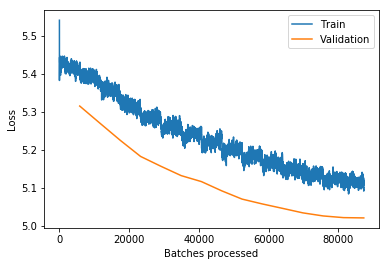

In [28]:
learn.recorder.plot_losses()

In [29]:
learn.save_encoder(enc_name)
learn.save(f"twitter_es_{seed}{'_bwd' if backward else ''}")
df_metrics = pd.DataFrame(np.array(learn.recorder.metrics),columns=learn.recorder.metrics_names)
print(f"LM RndSeed: {seed},{df_metrics['accuracy'].max()}")

LM RndSeed: 504940,0.3297465145587921
